In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import mlflow

In [2]:
#mlflow.sklearn.autolog()
#mlflow.tensorflow.autolog()
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

In [3]:
df_2022 = pd.read_csv('../../Tweet_Sentiment/BIST100/2022_final.csv').drop(['fark', 'tweet_count'], axis= 1).set_index('Unnamed: 0').sort_index()
df_2021 = pd.read_csv('../../Tweet_Sentiment/BIST100/2021_final.csv').drop(['fark', 'tweet_count'], axis= 1).set_index('Unnamed: 0').sort_index()
df = pd.concat([df_2022, df_2021]).sort_index()
df

,şimdi,açılış,avg_polar
Unnamed: 0,,,
2021-01-04,1495.43,1482.17,0.598575
2021-01-05,1489.56,1492.19,0.543668
2021-01-06,1505.42,1501.61,0.557471
2021-01-07,1522.24,1511.60,0.535849
2021-01-08,1540.61,1526.51,0.562334
...,...,...,...
2022-10-12,3517.75,3576.84,0.488859
2022-10-13,3553.43,3529.78,0.497640
2022-10-14,3626.96,3584.94,0.479313


In [4]:
scaler = MinMaxScaler()
scaler = scaler.fit(df)
df_for_training_scaled = scaler.transform(df)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit(df.loc[:,['şimdi']])

MinMaxScaler()

In [5]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (443, 5, 3).
TrainY shape = (443, 1, 1).


In [6]:
X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-1], trainY, test_size=30, shuffle=False)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=30, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((413, 5, 2), (413, 5, 3))

In [7]:
def build_model(input_shape):
    tf.keras.utils.set_random_seed(42)
    model = Sequential()
    
    model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 128))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [26]:
lstm_model_without_twitter=build_model((X_train_lstm_without_twitter.shape[1],X_train_lstm_without_twitter.shape[2]))
lstm_model_twitter=build_model((X_train_lstm_twitter.shape[1],X_train_lstm_twitter.shape[2]))

history_without_twitter = lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=50, batch_size=64, verbose=1, )

history_twitter = lstm_model_twitter.fit(X_train_lstm_twitter, y_train_lstm_twitter, epochs=50, batch_size=64, verbose=1, )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 256)            265216    
                                                                 
 dropout_12 (Dropout)        (None, 5, 256)            0         
                                                                 
 lstm_13 (LSTM)              (None, 5, 256)            525312    
                                                                 
 dropout_13 (Dropout)        (None, 5, 256)            0         
                                                                 
 lstm_14 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                

7/7 [==============================] - 0s 11ms/step - loss: 0.0027
Epoch 5/65
7/7 [==============================] - 0s 11ms/step - loss: 0.0022
Epoch 6/65
7/7 [==============================] - 0s 11ms/step - loss: 0.0015
Epoch 7/65
7/7 [==============================] - 0s 11ms/step - loss: 0.0016
Epoch 8/65
7/7 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 9/65
7/7 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 10/65
7/7 [==============================] - 0s 11ms/step - loss: 9.0729e-04
Epoch 11/65
7/7 [==============================] - 0s 11ms/step - loss: 7.6596e-04
Epoch 12/65
7/7 [==============================] - 0s 11ms/step - loss: 9.3671e-04
Epoch 13/65
7/7 [==============================] - 0s 11ms/step - loss: 9.3126e-04
Epoch 14/65
7/7 [==============================] - 0s 11ms/step - loss: 8.4949e-04
Epoch 15/65
7/7 [==============================] - 0s 11ms/step - loss: 9.3737e-04
Epoch 16/65
7/7 [============================

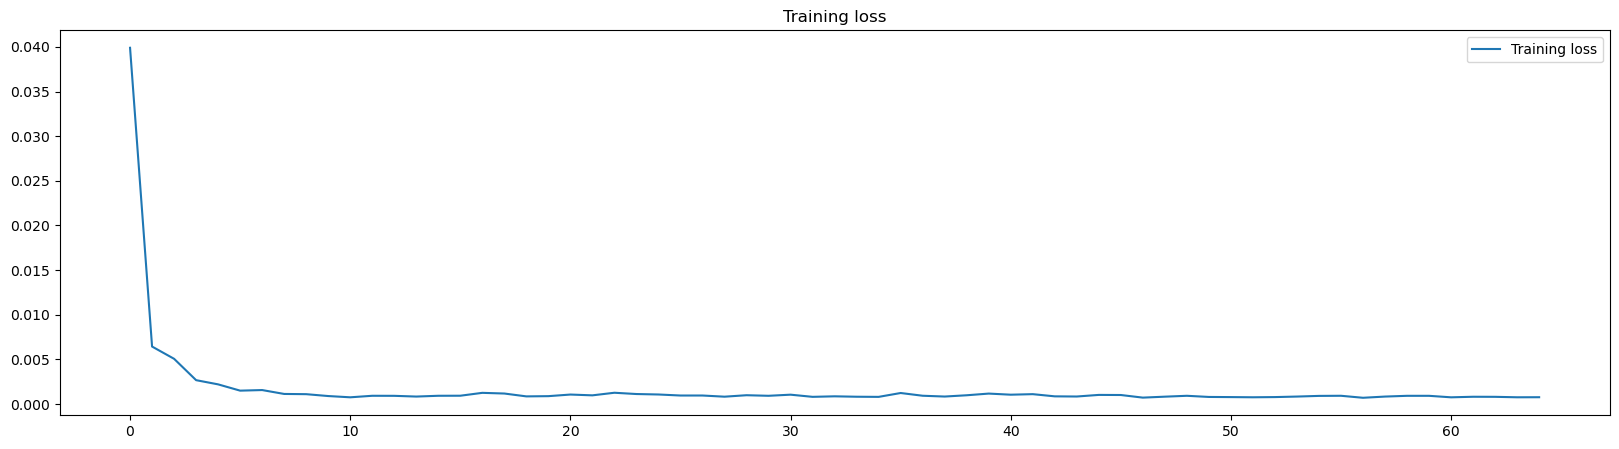

In [27]:
plt.figure(figsize=(20,5))
plt.plot(history_twitter.history['loss'], label='Training loss')
plt.title('Training loss')
plt.legend()

In [28]:
training_dates= df.index[:X_train_lstm_without_twitter.shape[0]]
#Make prediction
training_prediction_without_twitter = lstm_model_without_twitter.predict(X_train_lstm_without_twitter)

training_prediction_twitter = lstm_model_twitter.predict(X_train_lstm_twitter)

y_train_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(training_prediction_without_twitter)

y_train_pred_lstm_twitter = scaler_for_inference.inverse_transform(training_prediction_twitter)

y_train_lstm_reshaped_without_twitter=y_train_lstm_without_twitter.reshape(y_train_lstm_without_twitter.shape[0], y_train_lstm_without_twitter.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_twitter)

13/13 [==============================] - 1s 9ms/step


In [29]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['şimdi']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if twitter :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

In [30]:
testing_dates= df.index[-X_test_lstm_without_twitter.shape[0]:]
#Make prediction
testing_prediction_without_twitter = lstm_model_without_twitter.predict(X_test_lstm_without_twitter)
testing_prediction_twitter = lstm_model_twitter.predict(X_test_lstm_twitter)

y_test_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(testing_prediction_without_twitter)
y_test_pred_lstm_twitter = scaler_for_inference.inverse_transform(testing_prediction_twitter)

y_test_actual_lstm_reshaped_without_twitter=y_test_lstm_without_twitter.reshape(y_test_lstm_without_twitter.shape[0], y_test_lstm_without_twitter.shape[2])


y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_twitter)

1/1 [==============================] - 0s 23ms/step


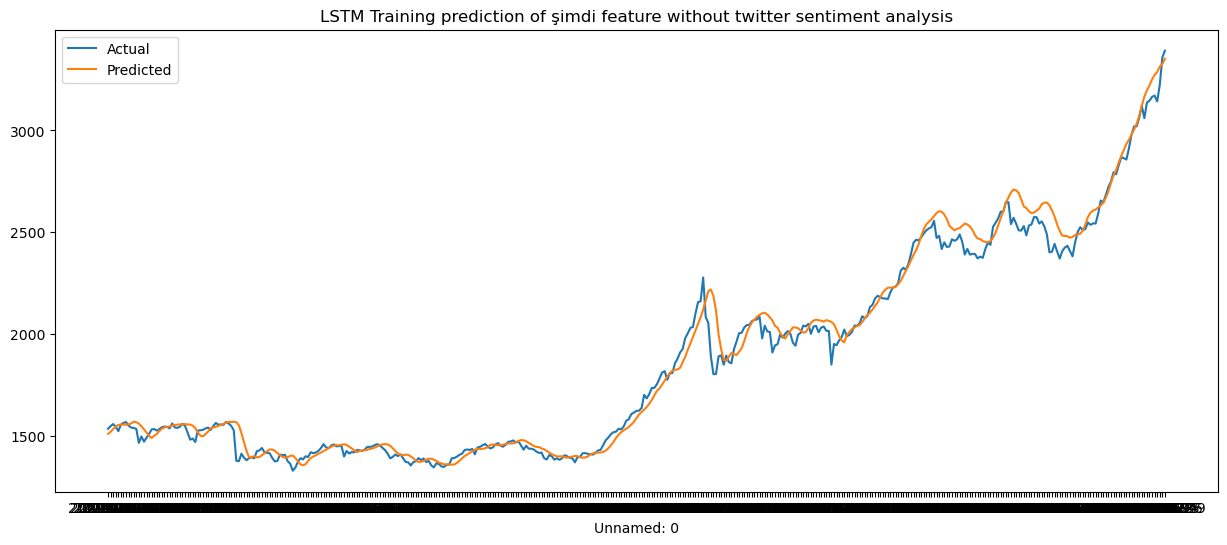

Mean square error for şimdi =4083.174491265266
Total mean square error 4083.174491265266


In [31]:
training_dates= df.index[:X_train_lstm_twitter.shape[0]]
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm ,y_train_pred_lstm_without_twitter)

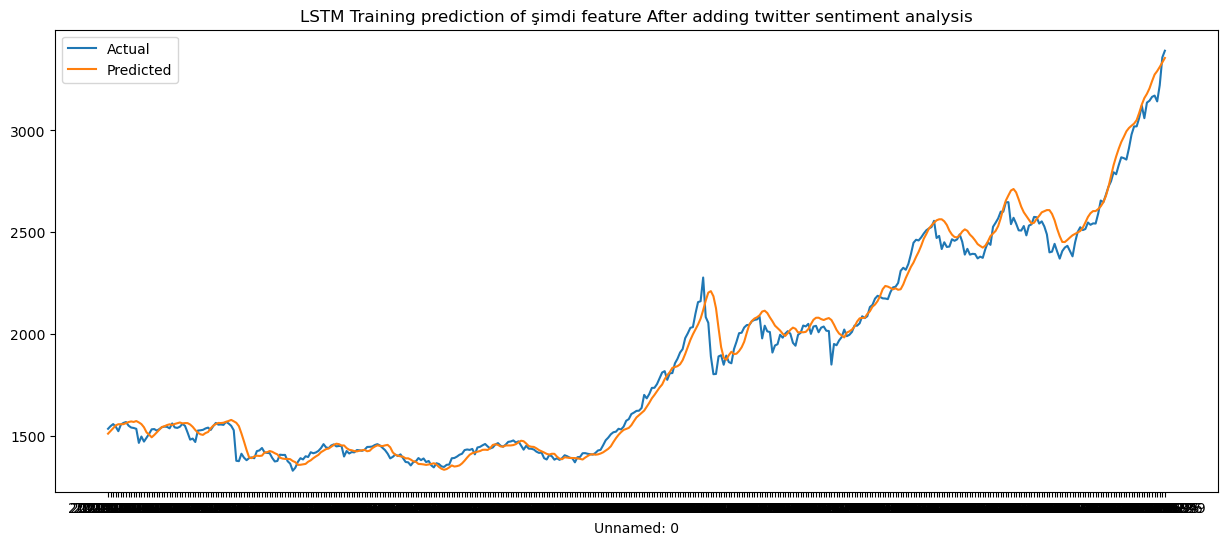

Mean square error for şimdi =3737.735300530527
Total mean square error 3737.735300530527


In [32]:
training_dates= df.index[:X_train_lstm_twitter.shape[0]]
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm ,y_train_pred_lstm_twitter)

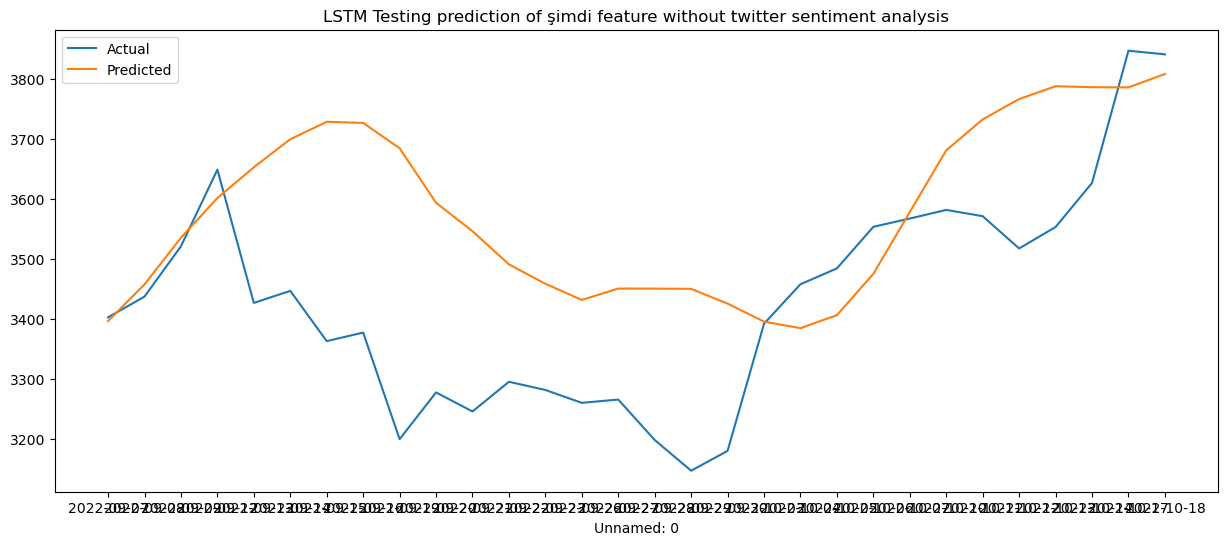

Mean square error for şimdi =45057.98173199586
Total mean square error 45057.98173199586


In [33]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_twitter)

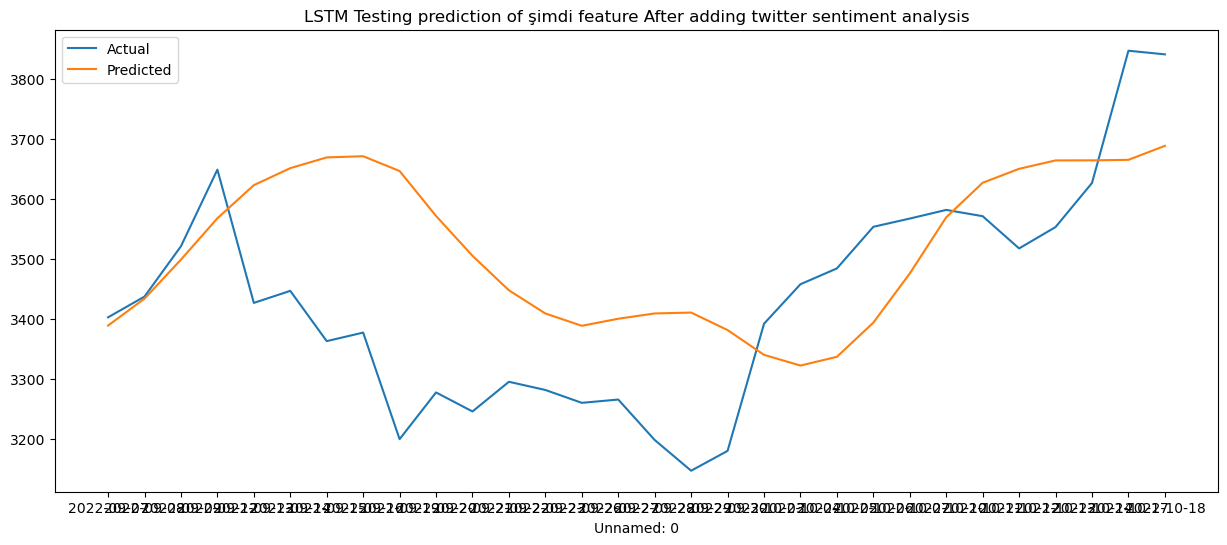

Mean square error for şimdi =33988.84759711006
Total mean square error 33988.84759711006


In [34]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_twitter)